In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import ast
import scipy
import mdtraj as md
import MDAnalysis
from typing import Dict, Tuple
import os
import seaborn as sns
from sklearn.linear_model import LinearRegression

# matplotlib settings
# --- Publication style settings ---
plt.rcParams.update({
    # Font
    "font.family": "Times New Roman",
    "font.serif": ["Arial"],  # or other preferred serif font
    "mathtext.fontset": "cm",            # Computer Modern for math text
    "text.usetex": False,                 # Use LaTeX for text rendering]
    "pdf.fonttype": 42,                 # Use LaTeX for text rendering

    # Figure
    "figure.figsize": (6, 4),            # width, height in inches
    "figure.dpi": 150,                   # medium resolution

    # Axes
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "axes.linewidth": 1.2,
    "axes.grid": True,                   # optional, remove if you want no grid
    "grid.linestyle": "--",
    "grid.alpha": 0.7,

    # Ticks
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,

    # Lines
    "lines.linewidth": 2,
    "lines.markersize": 6,

    # Legend
    "legend.fontsize": 10,
    "legend.frameon": False
})

def find_xtc_filenames(path_to_dir, suffix=".xtc"):
    filenames = os.listdir(path_to_dir)
    return [filename for filename in filenames if filename.endswith(suffix)]

# Function to calculate helical fraction
def helical_fraction(ss_line):
    helix_chars = {'H', 'G', 'I'}
    n_residues = len(ss_line)
    n_helical = sum(1 for c in ss_line if c in helix_chars)
    return n_helical / n_residues

# Function to calculate per-residue helicity per frame
def dssp_to_helicity(dssp_lines):
    """
    Convert DSSP strings into a binary helicity matrix.
    
    Parameters
    ----------
    dssp_lines : list of str
        Each entry corresponds to one frame.
        Each string is the DSSP assignment per residue for that frame.
    
    Returns
    -------
    helicity : np.ndarray
        Array of shape (n_frames, n_residues).
        1 = helix ('H', 'G', 'I'), 0 = non-helix.
    """
    helix_codes = {'H', 'G', 'I'}
    
    n_frames = len(dssp_lines)
    n_residues = len(dssp_lines[0])
    
    helicity = np.zeros((n_frames, n_residues), dtype=int)
    
    for i, line in enumerate(dssp_lines):
        helicity[i, :] = [1 if c in helix_codes else 0 for c in line]
    
    return helicity

# functions for SAXS analysis
def parse_gensaxs_dat(filename: str):

    df = pd.read_csv(filename)
    # drop index column
    df = df.drop(columns=["Unnamed: 0"])
    q = np.array(df.columns).astype(float) # shape (n_obs, )
    I_gen = np.array(df) # shape (n_samples, n_obs)

    return q, I_gen

# function to fit saxs curves to experimental curves & calculate chi2
def fit_SAXS(I_gen, I_exp, I_exp_err):

    wlr = 1/(I_exp_err**2)

    model = LinearRegression()
    model.fit(I_gen.reshape(-1,1),I_exp,wlr)
    alpha = model.coef_[0]
    beta = model.intercept_

    scaled = alpha*I_gen+beta

    # Calculate chi^2
    N = len(I_gen)
    chi2 = ((I_exp - scaled)**2 / I_exp_err**2).sum()
    chi2red = chi2/N

    return chi2red, scaled

data_path = '../Ensemble_reweighting/'

18


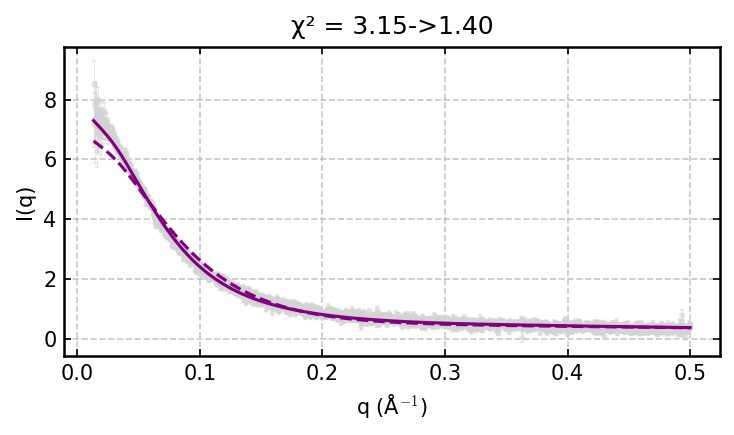

In [3]:
# prior vs posterior

protein = 'ACTR_OPES_310K_ensemble'

# reweighting directory
rew_dir = 'opes_rew_cs_pre/'
tc = 5.0 # tauc value used

# Load data
wopt_array = np.load(data_path+rew_dir+f'rew_wopt_array{tc}ns.npy')
neffs = np.loadtxt(data_path+rew_dir+f'rew_neffs{tc}ns.txt')
# Find the last index where neffs > 0.2
idx_opt = np.where(neffs > 0.2)[0][-1]
print(idx_opt)
# PRE frames
PREframes = np.loadtxt(data_path+rew_dir+"PREframes.txt").astype(int)
prior_weights = np.ones(wopt_array[0].shape[0])/wopt_array[0].shape
#prior_weights = np.loadtxt(protein+"/weights_310K.txt")[PREframes]

traj_names = np.sort(find_xtc_filenames(f'./{protein}/'))

# load SAXS data
for i in range(len(traj_names)):
    if i==0:
        q, I_gen = parse_gensaxs_dat(data_path+f'./{protein}/pepsisaxs_318K/saxs_curves_{traj_names[i][:-4]}.csv')
    else:
        q, tmpI_gen = parse_gensaxs_dat(data_path+f'./{protein}/pepsisaxs_318K/saxs_curves_{traj_names[i][:-4]}.csv')
        I_gen= np.concatenate((I_gen, tmpI_gen), axis=0)

# experimental data
SAXS = np.loadtxt(data_path+f'./exp_data_ACTR/SAXS_bift_318K.dat')


avg_I_gen = np.average(I_gen[PREframes], axis=0, weights=prior_weights)
chi2r_prior, scaled_prior = fit_SAXS(avg_I_gen, SAXS[:,1], SAXS[:,2])
avg_I_gen = np.average(I_gen[PREframes], axis=0, weights=wopt_array[idx_opt])
chi2r_post, scaled_post = fit_SAXS(avg_I_gen, SAXS[:,1], SAXS[:,2])

# plot
plt.figure(figsize = (5, 3))
plt.title(f"χ² = {chi2r_prior:.2f}->{chi2r_post:.2f}")

# experimental and ensemble averaged values
plt.errorbar(SAXS[:,0], SAXS[:,1], yerr=SAXS[:,2], color='lightgrey', alpha=0.5, fmt='o', capsize=1, markersize=2, elinewidth=0.5, rasterized=True)
plt.plot(q, scaled_prior, color="purple", label="Prior", linewidth=1.5, zorder=10, linestyle='dashed')
plt.plot(q, scaled_post, color="purple", label="Posterior", linewidth=1.5, zorder=20)

plt.xlabel('q (Å$^{-1}$)')
plt.ylabel('I(q)')
#plt.yscale('log')
plt.tight_layout()
plt.savefig(data_path+rew_dir+f"SAXS_prior_post.pdf")

In [4]:
# cross validation with PRE reweighting

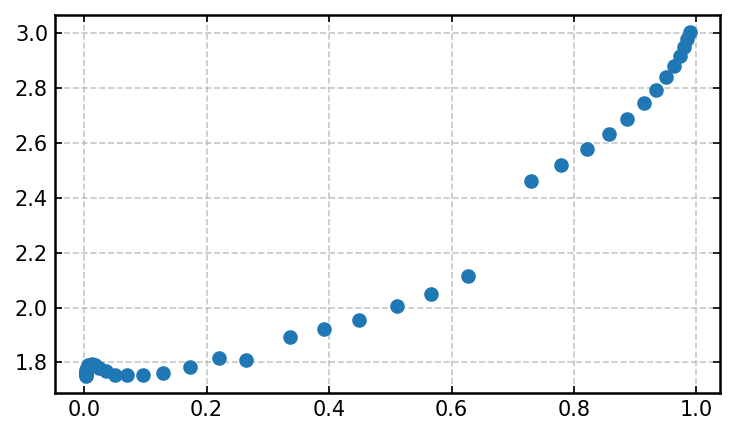

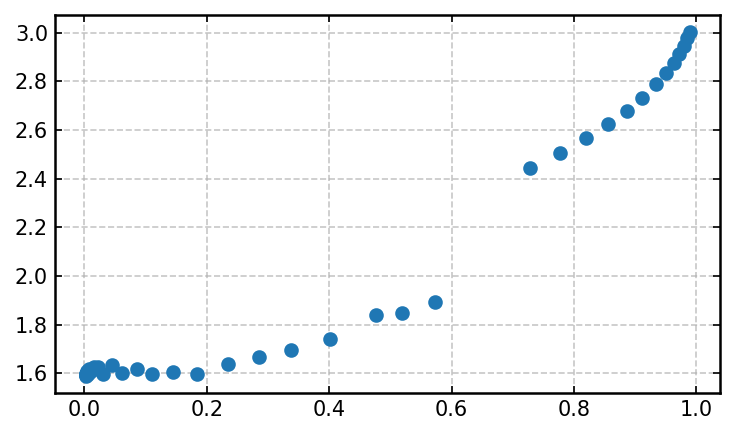

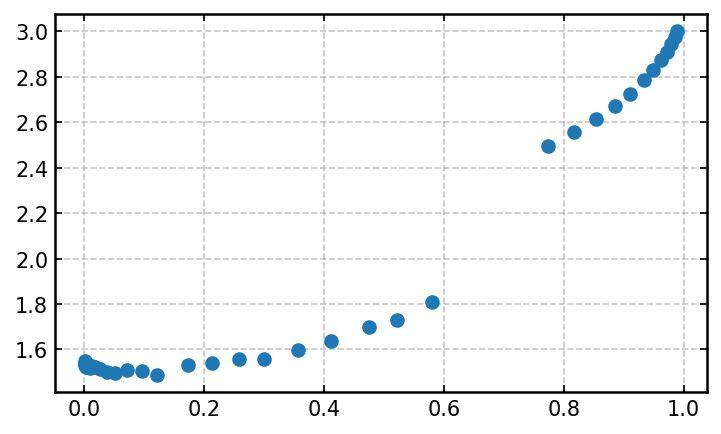

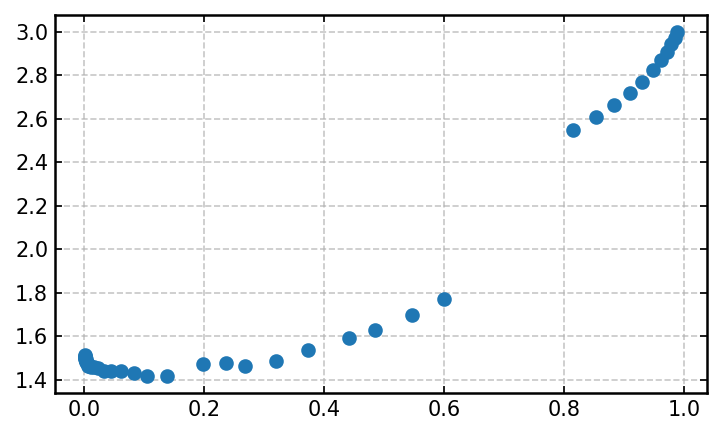

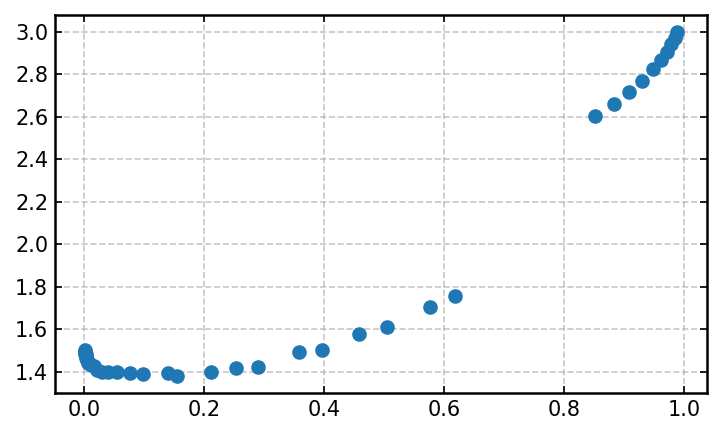

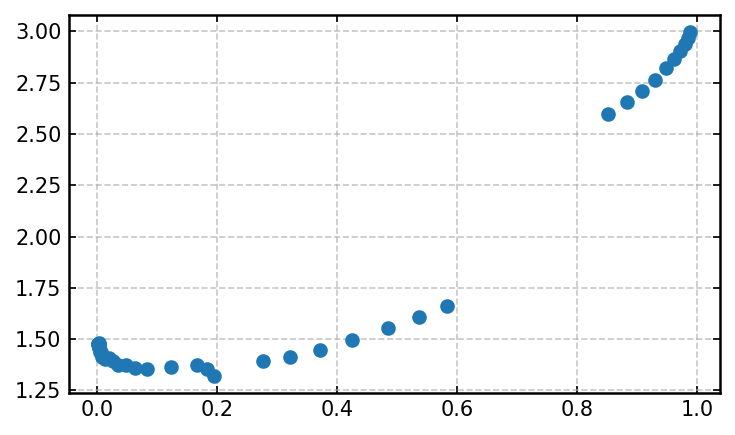

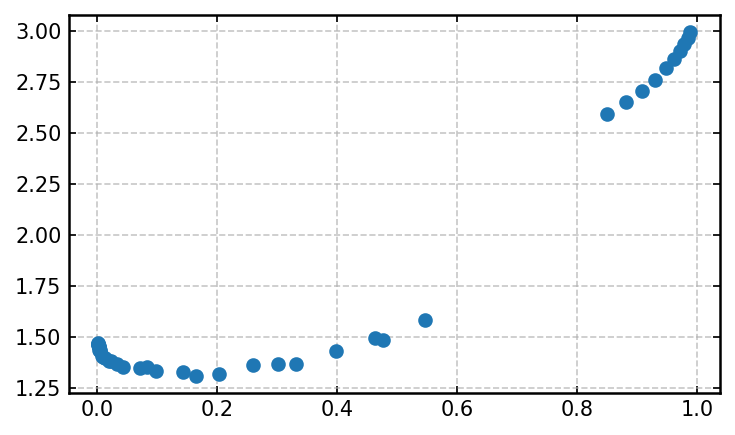

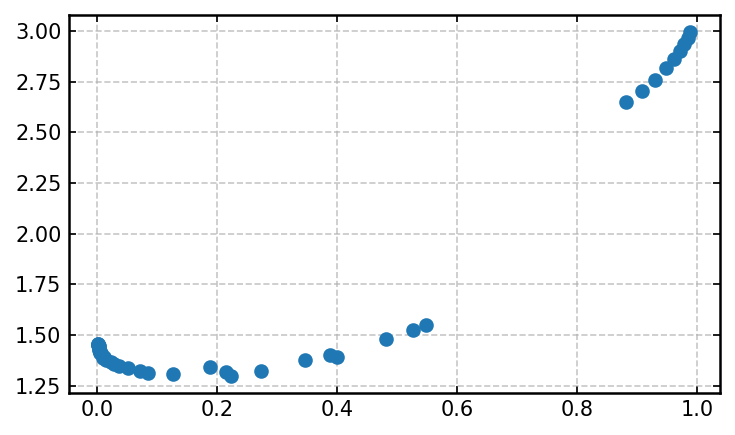

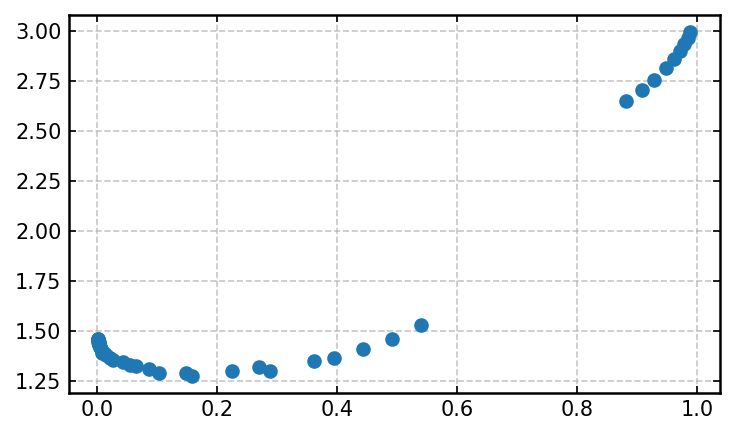

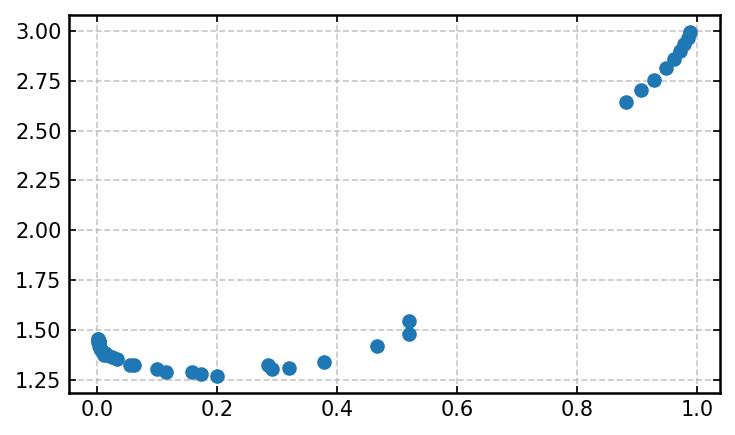

In [6]:
protein = 'ACTR_OPES_310K_ensemble'
rew_dir = 'opes_rew_cs_pre/'
tauc_values = np.arange(1.0, 11.0, 1.0)

frames = np.loadtxt(data_path+rew_dir+f"PREframes.txt").astype(int)
traj_names = np.sort(find_xtc_filenames(f'./{protein}/'))

# load SAXS data
for i in range(len(traj_names)):
    if i==0:
        q, I_gen = parse_gensaxs_dat(data_path+f'./{protein}/pepsisaxs_318K/saxs_curves_{traj_names[i][:-4]}.csv')
    else:
        q, tmpI_gen = parse_gensaxs_dat(data_path+f'./{protein}/pepsisaxs_318K/saxs_curves_{traj_names[i][:-4]}.csv')
        I_gen= np.concatenate((I_gen, tmpI_gen), axis=0)

I_gen = I_gen[frames]
# experimental data
SAXS = np.loadtxt(data_path+f'./exp_data_ACTR/SAXS_bift_318K.dat')

for tc in tauc_values:
    # load reweighting data
    wopt_array = np.load(data_path+rew_dir+f"rew_wopt_array{tc}ns.npy")
    neffs = np.loadtxt(data_path+rew_dir+f"rew_neffs{tc}ns.txt")
    relESS = []
    SAXS_chi2 = []
    for W in wopt_array:
        avg_I_gen = np.average(I_gen, axis=0, weights=W)
        chi2r, scaled = fit_SAXS(avg_I_gen, SAXS[:,1], SAXS[:,2])
        SAXS_chi2.append(chi2r)
        relESS.append((np.sum(W)**2/np.sum(W**2))/W.shape[0])


    # save data
    np.savetxt(data_path+rew_dir+f"SAXS_chi2r_{tc}ns.txt", SAXS_chi2)

    # plot
    plt.figure(figsize = (5, 3))



    plt.plot(neffs, SAXS_chi2, 'o')

    plt.tight_layout()
    plt.show()

